In [1]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from tqdm import tqdm
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from datetime import datetime
from torchvision import models
from transformers import CLIPProcessor, CLIPModel
import os
import csv
from peft import LoraConfig, get_peft_model

In [3]:
root = "/content/drive/MyDrive/MASTER_THESIS/"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [7]:
once_runned = False

In [8]:
openclip_model_name = "ViT-B-16-plus-240"
openclip_pretrained = "laion400m_e32"

#openclip_model_name = "ViTamin-XL-384"
#openclip_pretrained = "datacomp1b"
# ==> Better results than ViT-B-16-plus-240 but not avaialble in pt_multilingual_clip

model, _, preprocess = open_clip.create_model_and_transforms(openclip_model_name, pretrained=openclip_pretrained)
openclip_tokenizer = open_clip.get_tokenizer(openclip_model_name)
model.to(device)

transform = preprocess # Maybe more ?

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/834M [00:00<?, ?B/s]

In [9]:
FULL_DATASET = pd.read_csv(root + "fabritius_data_filtered_downloaded.csv")
# Remove rows with corrupted images
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 11546]
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 5262]
FULL_DATASET = FULL_DATASET.sample(frac=1.0).reset_index(drop=True)
FULL_DATASET

,recordLanguage,recordID,DatabaseId,LinkToVubis,objectWork.creatorDescription,objectWork.termClassification,objectWork.workID,objectWork.titleText,objectWork.objectWorkType,objectWork.measurementsDescription,...,objectWorkType_is_esquisse,objectWorkType_is_estampe,objectWorkType_is_grisaille,objectWorkType_is_photographie,objectWorkType_is_polyptyque,objectWorkType_is_retable,objectWorkType_is_sanguine,objectWorkType_is_triptyque,objectWorkType_is_ébauche,contains_desired_objectWorkType
0,fre,8456,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Alfred Stevens,oeuvre sur papier (Dept. Art Moderne),11671,"Dessin préparatoire au 'Panorama du siècle', '...",['esquisse'],NaN,...,True,False,False,False,False,False,False,False,False,True
1,fre,1291,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,baron Franz Courtens,peinture (Dept. Art Moderne),4967,La roulotte,['tableau (toile)'],"[35.0, 57.0]",...,False,False,False,False,False,False,False,False,False,True
2,fre,8538,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Jakob Smits,peinture (Dept. Art Moderne),6291,Matin,['tableau (panneau)'],"[45.0, 61.0]",...,False,False,False,False,False,False,False,False,False,True
3,fre,8281,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Amédée Lynen,oeuvre sur papier (Dept. Art Moderne),3669,Kermesse,['aquarelle'],NaN,...,False,False,False,False,False,False,False,False,False,True
4,fre,3903,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Georges Lemmen,oeuvre sur papier (Dept. Art Moderne),11517,Mère et enfant au biberon,['gouache'],NaN,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,fre,4449,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Antoine Wiertz,peinture (Dept. Art Moderne),1946,Les Grecs et les Troyens se disputant le corps...,['tableau (toile)'],"[520.0, 852.0]",...,False,False,False,False,False,False,False,False,False,True
3006,fre,1341,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Jacques d'Arthois (atelier de) ; figures d'une...,peinture (Dept. Art Ancien),4,La conversion de saint Hubert,['tableau (toile)'],"[237.0, 186.0]",...,False,False,False,False,False,False,False,False,False,True
3007,fre,6277,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Lucien Wollès,oeuvre sur papier (Dept. Art Moderne),4440,Portrait d'Adrien Joseph Heymans,['pastel'],NaN,...,False,False,False,False,False,False,False,False,False,True
3008,fre,10863,Fabritius,http://193.190.214.119/fabritiusweb/LinkToVubi...,Charles de la Fosse,oeuvre sur papier (Dept. Art Ancien),4060 / 2133,Gladiateur,"['dessin', 'étude']",NaN,...,False,False,False,False,False,False,False,False,False,True


In [10]:
def fixPath(path):
    return path.replace(".././", "../")

def get_image_path_from_recordID(dataset, recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = FULL_DATASET[
        FULL_DATASET["recordID"] == recordID
    ]["low_res_filename"].values

    if len(paths) == 0:
        return None

    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(root + "images/" + path[1:])
    return merged_path

In [34]:
TRAINING_CAPTIONS = pd.read_csv(root + "merged_data_training_set.csv")
# rows: recordID,category,focus,caption
TRAINING_CAPTIONS

,recordID,category,focus,caption,length_tokenization
0,7059,Dessin,content,Un texte entouré d'enfants anges avec des femm...,25
1,1352,Tableau,emotion,"Une maison dans une forêt aux arbres sombres, ...",39
2,4144,Tableau,emotion,"Un chemin de terre entre des collines sombres,...",33
3,4144,Tableau,emotion,"Un chemin de terre entre des collines sombres,...",32
4,4070,Tableau,content,"Couloir d'une maison avec un escalier, porte o...",26
...,...,...,...,...,...
977,6710,Tableau,emotion,Portrait d'un soldat en uniforme vu de profil ...,51
978,6710,Tableau,emotion,Portrait d'un soldat en uniforme vu de profil ...,49
979,6710,Tableau,emotion,Portrait d'un soldat en uniforme vu de profil ...,49
980,1202,Tableau,colors,"Des hommes qui parlent à un sultan, des soldat...",34


In [35]:
VALIDATION_CAPTIONS = pd.read_csv(root + "merged_data_validation_set.csv")
# rows: recordID,category,focus,caption
VALIDATION_CAPTIONS

,recordID,category,focus,caption,length_tokenization
0,5002,Tableau,luminosity,"Une fête, un repas, une foule en intérieur, de...",30
1,10900,Tableau,luminosity,"Une femme joue du piano, elle lit une partitio...",36
2,5510,Dessin,luminosity,"Un adolescente est assise contre le mur, elle ...",28
3,4576,Tableau,content,"Un paysage avec un ciel nuageux, un lac en fon...",22
4,7689,Tableau,emotion,"Des hommes barbus et moustachus qui discutent,...",26
...,...,...,...,...,...
949,3904,Tableau,content,Une jeune femme avec longue robe blanche desce...,27
950,4072,Tableau,content,"Portrait d'une jeune femme qui lit un livre, v...",24
951,1294,Tableau,emotion,Un paysage désolé avec des arbres sans feuille...,31
952,482,Tableau,colors,Portrait d'une jeune femme avec une robe noire...,33


In [36]:
model_metadatas = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "model_name": openclip_model_name,
    "pretrained": openclip_pretrained,
    "dataset": {
        "name": "training_set_captions",
        "size": len(TRAINING_CAPTIONS),
        "size_recordID": len(TRAINING_CAPTIONS["recordID"].unique()),
        "size_per_category": TRAINING_CAPTIONS.groupby("category").size().to_dict(),
        "size_per_focus": TRAINING_CAPTIONS.groupby("focus").size().to_dict(),
    },
    "hyperparameters": {
        "batch_size": 128, #256, # 32 = 8 <==> 128 = 23
        "num_epochs": 10,
        "learning_rate": 1e-6,
        "weight_decay": 0.04,
    }
}
# Save model_metadatas
with open(root + f"model_metadatas_{model_metadatas['timestamp']}.json", "w") as f:
    json.dump(model_metadatas, f)
model_metadatas

{'timestamp': '2025-02-05 00:20:40',
 'model_name': 'ViT-B-16-plus-240',
 'pretrained': 'laion400m_e32',
 'dataset': {'name': 'training_set_captions',
  'size': 982,
  'size_recordID': 227,
  'size_per_category': {'Dessin': 352, 'Sculpture': 15, 'Tableau': 615},
  'size_per_focus': {'colors': 195,
   'content': 227,
   'emotion': 425,
   'luminosity': 135}},
 'hyperparameters': {'batch_size': 128,
  'num_epochs': 10,
  'learning_rate': 1e-06,
  'weight_decay': 0.04}}

In [37]:
# Training sets
class FinetuningDataset(Dataset):
    def __init__(self, dataframe, getImageFromRecordID, transform=None):
        self.dataframe = dataframe
        self.getImageFromRecordID = getImageFromRecordID
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.dataframe.iloc[idx]

        recordID = row['recordID']
        caption = row['caption']
        path = self.getImageFromRecordID(self.dataframe, recordID)

        path = path.replace("internet", "Internet")
        path = path.replace("Mod", "mod")
        path = path.replace("Old", "old")
        path = path.replace("Stefaan", "stefaan")
        path = path.replace("Art-Foto", "art-foto")
        image = Image.open(path)#.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, caption, recordID

# Training dataset with only content focus
DATASET__TRAINING_ONLY_CONTENT_FOCUS = FinetuningDataset(TRAINING_CAPTIONS[TRAINING_CAPTIONS["focus"] == "content"], get_image_path_from_recordID, transform)
DATASET__TRAINING_ALL_FOCUS          = FinetuningDataset(TRAINING_CAPTIONS, get_image_path_from_recordID, transform)

# Make dataloaders
DATALOADER__TRAINING_ONLY_CONTENT_FOCUS = DataLoader(DATASET__TRAINING_ONLY_CONTENT_FOCUS, batch_size=model_metadatas["hyperparameters"]["batch_size"], shuffle=True, num_workers=0)
DATALOADER__TRAINING_ALL_FOCUS          = DataLoader(DATASET__TRAINING_ALL_FOCUS, batch_size=model_metadatas["hyperparameters"]["batch_size"], shuffle=True, num_workers=0)

# Print the lengths of the datasets and dataloaders
print("TRAINING_ONLY_CONTENT_FOCUS:", len(DATASET__TRAINING_ONLY_CONTENT_FOCUS), " | ", len(DATALOADER__TRAINING_ONLY_CONTENT_FOCUS))
print("TRAINING_ALL_FOCUS:", len(DATASET__TRAINING_ALL_FOCUS), " | ", len(DATALOADER__TRAINING_ALL_FOCUS))

TRAINING_ONLY_CONTENT_FOCUS: 227  |  2
TRAINING_ALL_FOCUS: 982  |  8


In [38]:
# Training_metrics & Validation sets
DATASET__VALIDATION_ALL_FOCUS = FinetuningDataset(VALIDATION_CAPTIONS, get_image_path_from_recordID, transform)
DATALOADER__VALIDATION_ALL_FOCUS = DataLoader(DATASET__VALIDATION_ALL_FOCUS, batch_size=model_metadatas["hyperparameters"]["batch_size"], shuffle=True, num_workers=0)

# Since we have multiple captions per image, we want to make a Dataset that allow us to measure the performance of the model on each focus
DATASET__TRAINING_PER_FOCUS     = {}
DATASET__VALIDATION_PER_FOCUS   = {}

for focus in ["content", "emotion", "colors", "luminosity"]:
    DATASET__TRAINING_PER_FOCUS[focus]      = FinetuningDataset(TRAINING_CAPTIONS[TRAINING_CAPTIONS["focus"] == focus], get_image_path_from_recordID, transform)
    DATASET__VALIDATION_PER_FOCUS[focus]    = FinetuningDataset(VALIDATION_CAPTIONS[VALIDATION_CAPTIONS["focus"] == focus], get_image_path_from_recordID, transform)

# Make dataloaders
DATALOADER__TRAINING_PER_FOCUS = {}
DATALOADER__VALIDATION_PER_FOCUS = {}
for focus in ["content", "emotion", "colors", "luminosity"]:
    DATALOADER__TRAINING_PER_FOCUS[focus] = DataLoader(DATASET__TRAINING_PER_FOCUS[focus], batch_size=model_metadatas["hyperparameters"]["batch_size"], shuffle=True, num_workers=0)
    DATALOADER__VALIDATION_PER_FOCUS[focus] = DataLoader(DATASET__VALIDATION_PER_FOCUS[focus], batch_size=model_metadatas["hyperparameters"]["batch_size"], shuffle=True, num_workers=0)

# Print the lengths of the datasets and dataloaders
sizes = pd.DataFrame(columns=["focus", "Dataset (training)", "Dataset (validation)", "Dataloader (training)", "Dataloader (validation)"])
for focus in ["content", "emotion", "colors", "luminosity"]:
    sizes.loc[len(sizes)] = [focus, len(DATASET__TRAINING_PER_FOCUS[focus]), len(DATASET__VALIDATION_PER_FOCUS[focus]), len(DATALOADER__TRAINING_PER_FOCUS[focus]), len(DATALOADER__VALIDATION_PER_FOCUS[focus])]

sizes

,focus,Dataset (training),Dataset (validation),Dataloader (training),Dataloader (validation)
0,content,227,227,2,2
1,emotion,425,378,4,3
2,colors,195,207,2,2
3,luminosity,135,142,2,2


In [39]:
def loss_fn(image_features, text_features):
    # from : https://github.com/revantteotia/clip-training/blob/main/train.py
    logit_scale = model.logit_scale.exp()

    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logit_scale * text_features @ image_features.t()

    labels = torch.arange(len(logits_per_image)).to(logits_per_image.device)

    image_loss = F.cross_entropy(logits_per_image, labels)
    text_loss  = F.cross_entropy(logits_per_text, labels)

    loss = (image_loss + text_loss) / 2

    return loss

optimizer = optim.AdamW(model.parameters(), lr=model_metadatas["hyperparameters"]["learning_rate"], weight_decay=model_metadatas["hyperparameters"]["weight_decay"])

In [40]:
def get_average_position(cosine_similarities):
    """
    What is the Average Position?
    ==> The Average Position is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the average of the positions of the correct answers.
    ==> The position of a query response is the rank of the first correct answer.
    ==> The Average Position is a number between 0 and n, where 0 means that the first correct answer is always ranked first.
    """
    average_position = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        average_position += rank
    average_position /= len(cosine_similarities)
    return average_position

def get_MRR(cosine_similarities):
    """
    What is MRR (Mean Reciprocal Rank)?
    ==> The Mean Reciprocal Rank is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the average of the reciprocal ranks of the top k items.
    ==> The reciprocal rank of a query response is the multiplicative inverse of the rank of the first correct answer.
    ==> The MRR is a number between 0 and 1, where 1 means that the first correct answer is always ranked first.
    """
    mrr = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        mrr += 1 / rank
    mrr /= len(cosine_similarities)
    return mrr

def get_recall_at_k(cosine_similarities, k):
    """
    What is Recall@k?
    ==> The Recall@k is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the proportion of the top k items that are relevant.
    ==> The Recall@k is a number between 0 and 1, where 1 means that all top k items are relevant.
    """
    recall_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        if i in sorted_indices[:k]:
            recall_at_k += 1
    recall_at_k /= len(cosine_similarities)
    return recall_at_k

def get_nDCG_at_k(cosine_similarities, k):
    """
    What is nDCG@k (Discounted cumulative gain)
    ==> The nDCG@k is a metric that evaluates the effectiveness of a recommendation algorithm.
    ==> It is the normalized discounted cumulative gain at the top k items.
    ==> The nDCG@k is a number between 0 and 1, where 1 means that all top k items are relevant and perfectly ranked.
    """
    nDCG_at_k = 0
    for i in range(len(cosine_similarities)):
        sorted_indices = np.argsort(cosine_similarities[i])[::-1]
        rank = np.where(sorted_indices == i)[0][0] + 1
        nDCG_at_k += 1 / np.log2(rank + 1) if rank <= k else 0
    nDCG_at_k /= len(cosine_similarities)
    return nDCG_at_k

In [41]:
def benchmark_on_dataloader(model, dataset, dataloader, device):
    """
    This function measures various metrics on a dataloader:
    - Loss
    - Average Position
    - MRR (Mean Reciprocal Rank)
    - Recall@1, Recall@5, Recall@10
    - nDCG@1, nDCG@5, nDCG@10
    """
    model.eval()
    loss_tot = 0
    positions = []
    recalls = {1: 0, 5: 0, 10: 0}
    ndcgs = {1: 0, 5: 0, 10: 0}

    images_embeddings = torch.tensor([]).to(device)
    texts_embeddings = torch.tensor([]).to(device)

    with torch.no_grad():
        for images, captions, recordIDs in tqdm(dataloader):
            images = images.to(device)
            captions = openclip_tokenizer(captions).to(device)

            # Compute the embeddings
            image_embeddings = model.encode_image(images)
            text_embeddings = model.encode_text(captions)

            # Normalize
            image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
            text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

            # Compute the loss
            loss = loss_fn(image_embeddings, text_embeddings)
            loss_tot += loss.item()

            # Add the embeddings to the list
            images_embeddings = torch.cat((images_embeddings, image_embeddings), 0)
            texts_embeddings = torch.cat((texts_embeddings, text_embeddings), 0)

    # Compute the loss
    loss_per_pair = loss_tot/len(dataset) # Average loss per pair

    # Compute the cosine similarity
    similarities = images_embeddings @ texts_embeddings.T
    similarities = similarities.cpu().numpy()

    # Compute the positions
    average_position = get_average_position(similarities)
    mrr = get_MRR(similarities)
    recalls[1] = get_recall_at_k(similarities, 1)
    recalls[5] = get_recall_at_k(similarities, 5)
    recalls[10] = get_recall_at_k(similarities, 10)
    ndcgs[1] = get_nDCG_at_k(similarities, 1)
    ndcgs[5] = get_nDCG_at_k(similarities, 5)
    ndcgs[10] = get_nDCG_at_k(similarities, 10)

    return [loss_per_pair, average_position, mrr, recalls[1], recalls[5], recalls[10], ndcgs[1], ndcgs[5], ndcgs[10]]

In [42]:
def run_benchmark(model, epoch, training_df, validation_df, device):
    """
    There are quite a lot of benchmarks to run:
    1) Training set
        1.1) Training set (all focus)
        1.2) Training set (content focus)
        1.3) Training set (emotion focus)
        1.4) Training set (colors focus)
        1.5) Training set (luminosity focus)
    2) Validation set
        2.1) Validation set (all focus)
        2.2) Validation set (content focus)
        2.3) Validation set (emotion focus)
        2.4) Validation set (colors focus)
        2.5) Validation set (luminosity focus)
    ==> The "all" row is the mean of the other rows
    """
    def addRow(df, epoch, focus, results):
        df.loc[len(df)] = [epoch, focus] + results

    # Training set
    mean_row = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    for focus in ["content", "emotion", "colors", "luminosity"]:
        measures = benchmark_on_dataloader(model, TRAINING_CAPTIONS[TRAINING_CAPTIONS["focus"] == focus], DATALOADER__TRAINING_PER_FOCUS[focus], device)
        addRow(training_df, epoch, focus, measures)
        mean_row = [mean_row[i] + measures[i] for i in range(len(mean_row))]
    mean_row = [mean_row[i] / 4 for i in range(len(mean_row))]
    addRow(training_df, epoch, "all", mean_row)

    # Validation set
    mean_row = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    for focus in ["content", "emotion", "colors", "luminosity"]:
        measures = benchmark_on_dataloader(model, VALIDATION_CAPTIONS[VALIDATION_CAPTIONS["focus"] == focus], DATALOADER__VALIDATION_PER_FOCUS[focus], device)
        addRow(validation_df, epoch, focus, measures)
        mean_row = [mean_row[i] + measures[i] for i in range(len(mean_row))]
    mean_row = [mean_row[i] / 4 for i in range(len(mean_row))]
    addRow(validation_df, epoch, "all", mean_row)

In [43]:
def create_pd_tables():
    """
    There are quite a lot of benchmarks to run:
    1) Training set
        1.1) Training set (all focus)
        1.2) Training set (content focus)
        1.3) Training set (emotion focus)
        1.4) Training set (colors focus)
        1.5) Training set (luminosity focus)
    2) Validation set
        2.1) Validation set (all focus)
        2.2) Validation set (content focus)
        2.3) Validation set (emotion focus)
        2.4) Validation set (colors focus)
        2.5) Validation set (luminosity focus)
    ==> Create two DataFrames, one for training and one for validation
    """
    training_df = pd.DataFrame(columns=["epoch", "focus", "loss", "average_position", "mrr", "recall@1", "recall@5", "recall@10", "ndcg@1", "ndcg@5", "ndcg@10"])
    validation_df = pd.DataFrame(columns=["epoch", "focus", "loss", "average_position", "mrr", "recall@1", "recall@5", "recall@10", "ndcg@1", "ndcg@5", "ndcg@10"])
    return training_df, validation_df

In [44]:
# Plot the mrr for the training and validation sets for each focus
def plot_mrr(df, title, save_name):
    epochs = sorted(df["epoch"].unique())
    mrrs = {focus: [] for focus in ["all", "content", "emotion", "colors", "luminosity"]}

    for focus in ["all", "content", "emotion", "colors", "luminosity"]:
        for epoch in epochs:
            mrr = df[(df["epoch"] == epoch) & (df["focus"] == focus)]["mrr"].values[0]
            mrrs[focus].append(mrr)

    if len(epochs)==1:
      # Bar plot
      plt.figure(figsize=(10, 5))

      # Sorted by MRR (high to low)
      mrrs = {k: v for k, v in sorted(mrrs.items(), key=lambda item: item[1][-1], reverse=True)}

      for focus, mrr in mrrs.items():
        plt.bar(focus, mrr[-1], label=focus)

      plt.title(title)
      plt.xlabel("Focus")
      plt.ylabel("MRR")
      plt.ylim(0, 1)
      plt.grid()
      plt.savefig(root + save_name + ".pdf")
      plt.legend()
    else:
      # Plot the MRR for each focus (different colors) per epoch
      plt.figure(figsize=(10, 5))

      for focus in ["all", "content", "emotion", "colors", "luminosity"]:
          plt.plot(epochs, mrrs[focus], label=focus)

      plt.title(title)
      plt.xlabel("Epoch")
      plt.ylabel("MRR")
      plt.legend()
      plt.ylim(0, 1)
      plt.grid()
      plt.savefig(root + save_name + ".pdf")
      plt.show()

In [45]:
def plot_losses(training_df, validation_df, title, save_name):
    epochs = sorted(training_df["epoch"].unique())
    losses = {focus: [] for focus in ["all", "content", "emotion", "colors", "luminosity"]}

    for focus in ["all", "content", "emotion", "colors", "luminosity"]:
        for epoch in epochs:
            loss = training_df[(training_df["epoch"] == epoch) & (training_df["focus"] == focus)]["loss"].values[0]
            losses[focus].append(loss)

    # Plot the loss for each focus (different colors) per epoch
    plt.figure(figsize=(10, 5))

    for focus in ["all", "content", "emotion", "colors", "luminosity"]:
        plt.plot(epochs, losses[focus], label=focus)

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig(root + save_name + ".pdf")
    plt.show()

In [46]:
once_runned = False

100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


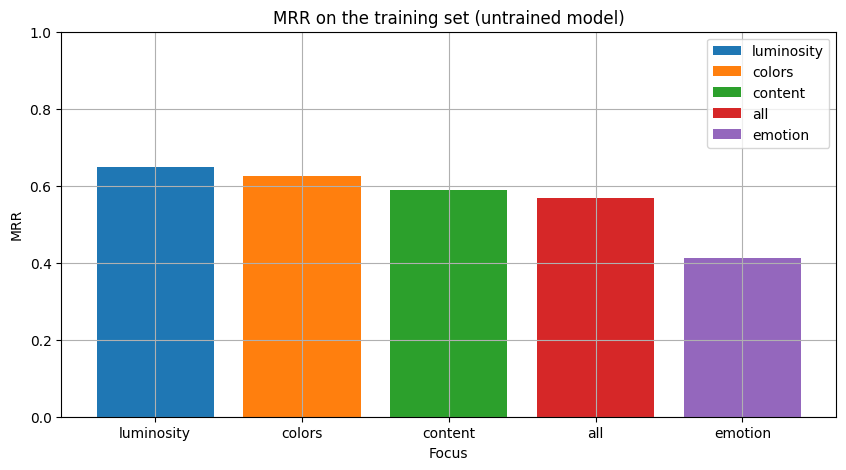

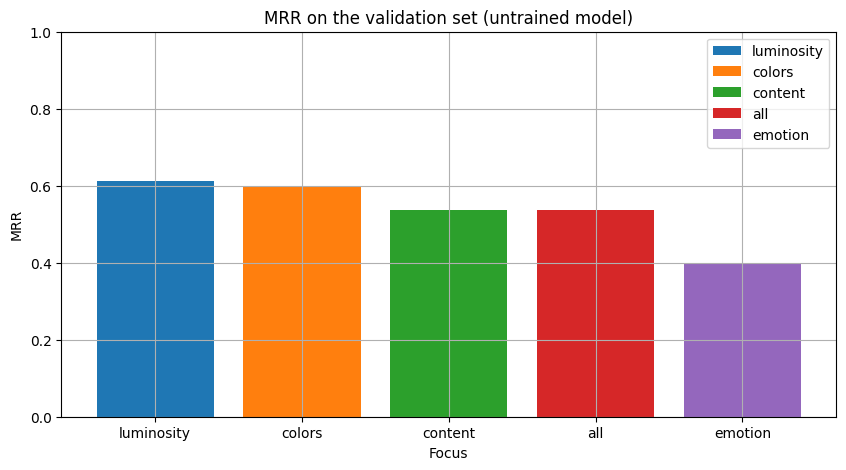

In [47]:
# Compute the metrics on the untrained model
if not once_runned:
    # Compute the metrics on the untrained model (SHOULD NOT BE RUN AGAIN)
    untrained_training_df, untrained_validation_df = create_pd_tables()
    run_benchmark(model, 0, untrained_training_df, untrained_validation_df, device)
    plot_mrr(untrained_training_df, "MRR on the training set (untrained model)", "untrained_training_mrr")
    plot_mrr(untrained_validation_df, "MRR on the validation set (untrained model)", "untrained_validation_mrr")
    once_runned = True

In [48]:
untrained_training_df

,epoch,focus,loss,average_position,mrr,recall@1,recall@5,recall@10,ndcg@1,ndcg@5,ndcg@10
0,0,content,0.016550,6.083700,0.589527,0.444934,0.762115,0.876652,0.444934,0.616443,0.653083
1,0,emotion,0.019240,13.327059,0.411506,0.228235,0.635294,0.778824,0.228235,0.444959,0.491935
2,0,colors,0.017018,5.656410,0.624307,0.482051,0.800000,0.892308,0.482051,0.655253,0.685126
3,0,luminosity,0.014396,4.496296,0.648828,0.503704,0.829630,0.940741,0.503704,0.679836,0.716553
4,0,all,0.016801,7.390866,0.568542,0.414731,0.756760,0.872131,0.414731,0.599123,0.636674


In [49]:
untrained_validation_df

,epoch,focus,loss,average_position,mrr,recall@1,recall@5,recall@10,ndcg@1,ndcg@5,ndcg@10
0,0,content,0.020855,8.475771,0.536262,0.396476,0.704846,0.823789,0.396476,0.560234,0.598581
1,0,emotion,0.019796,14.248677,0.395845,0.227513,0.597884,0.730159,0.227513,0.424825,0.467892
2,0,colors,0.017268,5.473430,0.598542,0.463768,0.787440,0.874396,0.463768,0.631520,0.659610
3,0,luminosity,0.024129,5.309859,0.612870,0.450704,0.788732,0.873239,0.450704,0.643708,0.671258
4,0,all,0.020512,8.376934,0.535880,0.384615,0.719725,0.825396,0.384615,0.565072,0.599335


In [50]:
def printMetrics(epoch, training_df, validation_df):
    combined_df = pd.DataFrame(columns=["Metric name", "Training", "Validation"])
    for metric in ["loss", "average_position", "mrr", "recall@1", "ndcg@1"]:
      for focus in ["all", "content", "emotion", "colors", "luminosity"]:
            training_metric = training_df[(training_df["epoch"] == epoch) & (training_df["focus"] == focus)][metric].values[0]
            validation_metric = validation_df[(validation_df["epoch"] == epoch) & (validation_df["focus"] == focus)][metric].values[0]
            combined_df.loc[len(combined_df)] = [metric + " (" + focus + ")", training_metric, validation_metric]

    for metric in ["loss", "average_position", "mrr", "recall@1", "ndcg@1"]:
      sub_df = combined_df[combined_df["Metric name"].str.contains(metric)]
      # Sort
      sub_df = sub_df.sort_values(by="Training", ascending=True)
      print(f"Metric: {metric}")
      print(sub_df)
      print()

# Test
printMetrics(0, untrained_training_df, untrained_validation_df)

Metric: loss
         Metric name  Training  Validation
4  loss (luminosity)  0.014396    0.024129
1     loss (content)  0.016550    0.020855
0         loss (all)  0.016801    0.020512
3      loss (colors)  0.017018    0.017268
2     loss (emotion)  0.019240    0.019796

Metric: average_position
                     Metric name   Training  Validation
9  average_position (luminosity)   4.496296    5.309859
8      average_position (colors)   5.656410    5.473430
6     average_position (content)   6.083700    8.475771
5         average_position (all)   7.390866    8.376934
7     average_position (emotion)  13.327059   14.248677

Metric: mrr
         Metric name  Training  Validation
12     mrr (emotion)  0.411506    0.395845
10         mrr (all)  0.568542    0.535880
11     mrr (content)  0.589527    0.536262
13      mrr (colors)  0.624307    0.598542
14  mrr (luminosity)  0.648828    0.612870

Metric: recall@1
              Metric name  Training  Validation
17     recall@1 (emotion)  0.2

In [51]:
def train_for_one_epoch(model, epoch, training_df, validation_df, dataloader, device):
    model.train()
    loss_tot = 0

    for images, captions, recordIDs in tqdm(dataloader):
        images = images.to(device)
        captions = openclip_tokenizer(captions).to(device)

        # Compute the embeddings
        image_embeddings = model.encode_image(images)
        text_embeddings = model.encode_text(captions)

        # Normalize
        image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
        text_embeddings = text_embeddings / text_embeddings.norm(dim=-1, keepdim=True)

        # Compute the loss
        loss = loss_fn(image_embeddings, text_embeddings)
        loss_tot += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the metrics for this epoch
    print("Running benchmark...")
    run_benchmark(model, epoch, training_df, validation_df, device)

    # Print the metrics
    printMetrics(epoch, training_df, validation_df)

In [52]:
def save_model_weights(model, type, epoch):
    fullIdentifier = model_metadatas["timestamp"] + "_" + type + "_" + str(epoch)
    torch.save(model.state_dict(), root + "models/" + fullIdentifier + ".pt")

In [53]:
print(torch.cuda.mem_get_info())
torch.cuda.empty_cache()
print(torch.cuda.mem_get_info())

(11977752576, 42474471424)
(38586417152, 42474471424)


# Training loop (only content focus)

In [54]:
# Reload the model !
model, _, _ = open_clip.create_model_and_transforms(openclip_model_name, pretrained=openclip_pretrained)
model.to(device)
print("Model reloaded !")

Model reloaded !


In [55]:
training_df_onlyFocus, validation_df_onlyFocus = create_pd_tables()
# Copy the rows from the untrained model
for i, row in untrained_training_df.iterrows():
    training_df_onlyFocus.loc[len(training_df_onlyFocus)] = row
for i, row in untrained_validation_df.iterrows():
    validation_df_onlyFocus.loc[len(validation_df_onlyFocus)] = row

print(len(untrained_training_df), len(training_df_onlyFocus))
print(len(untrained_validation_df), len(validation_df_onlyFocus))

5 5
5 5


In [56]:
# Training loop (only content focus)
for epoch in range(1, model_metadatas["hyperparameters"]["num_epochs"]+1):
    print("Epoch", epoch)
    train_for_one_epoch(model, epoch, training_df_onlyFocus, validation_df_onlyFocus, DATALOADER__TRAINING_ONLY_CONTENT_FOCUS, device)
save_model_weights(model, "onlyFocus", epoch)

Epoch 1


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Running benchmark...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Metric: loss
         Metric name  Training  Validation
4  loss (luminosity)  0.015020    0.018487
0         loss (all)  0.016787    0.019142
3      loss (colors)  0.016794    0.018275
1     loss (content)  0.017075    0.019892
2     loss (emotion)  0.018260    0.019914

Metric: average_position
                     Metric name   Training  Validation
9  average_position (luminosity)   4.496296    5.309859
8      average_position (colors)   5.656410    5.473430
6     average_position (content)   6.083700    8.475771
5         average_position (all)   7.390866    8.376934
7     average_position (emotion)  13.327059   14.248677

Metric: mrr
         Metric name  Training  Validation
12     mrr (emotion)  0.411506    0.395845
10         mrr (all)  0.568542    0.535880
11     mrr (content)  0.589527    0.536262
13      mrr (colors)  0.624307    0.598542
14  mrr (luminosity)  0.648828    0.612870

Metric: recall@1
              Metric name  Training  Validation
17     recall@1 (emotion)  0.2

100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


Running benchmark...


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Metric: loss
         Metric name  Training  Validation
4  loss (luminosity)  0.015097    0.018316
1     loss (content)  0.016622    0.019687
0         loss (all)  0.017142    0.018785
3      loss (colors)  0.017925    0.017658
2     loss (emotion)  0.018925    0.019482

Metric: average_position
                     Metric name   Training  Validation
9  average_position (luminosity)   4.496296    5.309859
8      average_position (colors)   5.656410    5.473430
6     average_position (content)   6.083700    8.475771
5         average_position (all)   7.390866    8.376934
7     average_position (emotion)  13.327059   14.248677

Metric: mrr
         Metric name  Training  Validation
12     mrr (emotion)  0.411506    0.395845
10         mrr (all)  0.568542    0.535880
11     mrr (content)  0.589527    0.536262
13      mrr (colors)  0.624307    0.598542
14  mrr (luminosity)  0.648828    0.612870

Metric: recall@1
              Metric name  Training  Validation
17     recall@1 (emotion)  0.2

100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Running benchmark...


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


Metric: loss
         Metric name  Training  Validation
1     loss (content)  0.016456    0.020360
2     loss (emotion)  0.017550    0.020183
3      loss (colors)  0.017961    0.018337
0         loss (all)  0.020856    0.020486
4  loss (luminosity)  0.031458    0.023063

Metric: average_position
                     Metric name   Training  Validation
9  average_position (luminosity)   4.496296    5.309859
8      average_position (colors)   5.656410    5.473430
6     average_position (content)   6.083700    8.475771
5         average_position (all)   7.390866    8.376934
7     average_position (emotion)  13.327059   14.248677

Metric: mrr
         Metric name  Training  Validation
12     mrr (emotion)  0.411506    0.395845
10         mrr (all)  0.568542    0.535880
11     mrr (content)  0.589527    0.536262
13      mrr (colors)  0.624307    0.598542
14  mrr (luminosity)  0.648828    0.612870

Metric: recall@1
              Metric name  Training  Validation
17     recall@1 (emotion)  0.2

100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


Running benchmark...


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


Metric: loss
         Metric name  Training  Validation
4  loss (luminosity)  0.015027    0.018832
1     loss (content)  0.016055    0.020037
0         loss (all)  0.016959    0.018874
3      loss (colors)  0.017890    0.016813
2     loss (emotion)  0.018865    0.019814

Metric: average_position
                     Metric name   Training  Validation
9  average_position (luminosity)   4.496296    5.309859
8      average_position (colors)   5.656410    5.473430
6     average_position (content)   6.083700    8.475771
5         average_position (all)   7.390866    8.376934
7     average_position (emotion)  13.327059   14.248677

Metric: mrr
         Metric name  Training  Validation
12     mrr (emotion)  0.411506    0.395845
10         mrr (all)  0.568542    0.535880
11     mrr (content)  0.589527    0.536262
13      mrr (colors)  0.624307    0.598542
14  mrr (luminosity)  0.648828    0.612870

Metric: recall@1
              Metric name  Training  Validation
17     recall@1 (emotion)  0.2

100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Running benchmark...


 50%|█████     | 1/2 [00:02<00:02,  2.78s/it]


KeyboardInterrupt: 

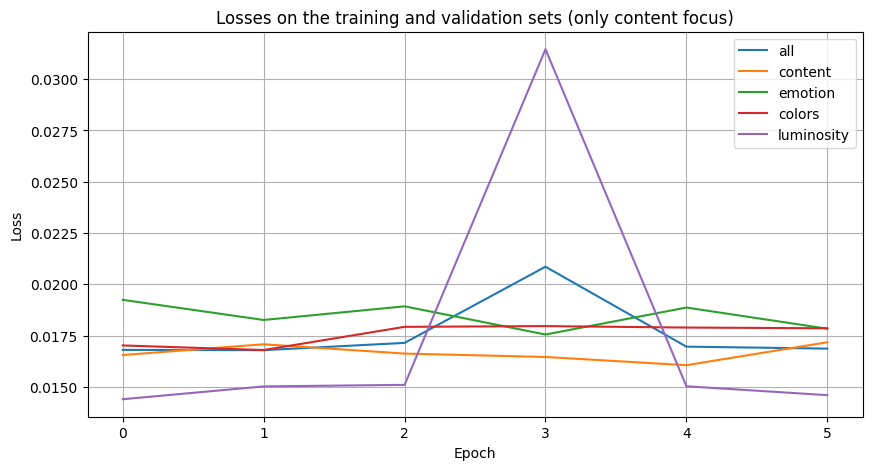

In [57]:
# Plot the losses for the training and validation sets for each focus
plot_losses(training_df_onlyFocus, validation_df_onlyFocus, "Losses on the training and validation sets (only content focus)", "losses_only_content_focus")

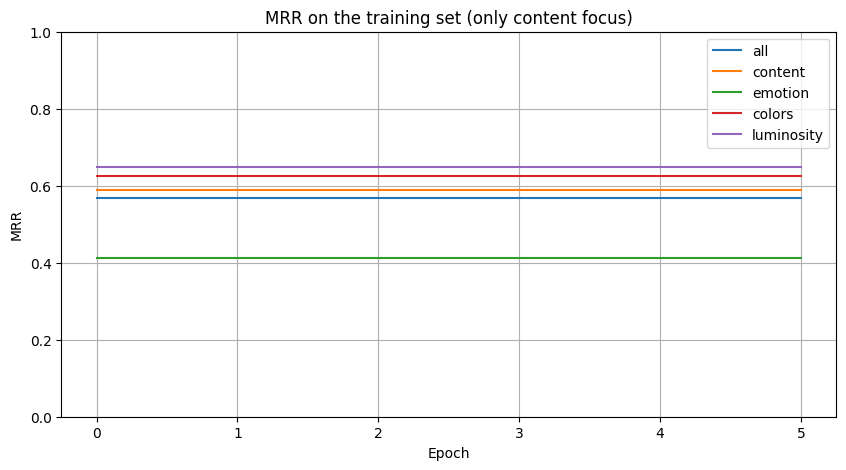

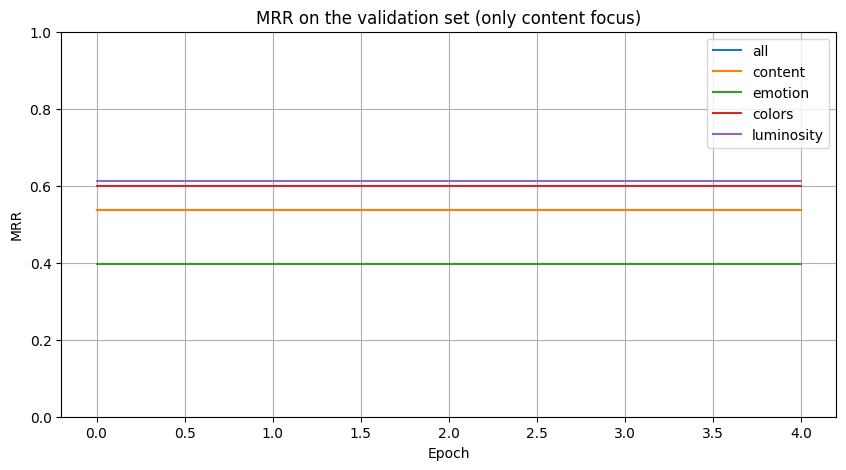

In [58]:
# Plot the MRR for the training and validation sets for each focus
plot_mrr(training_df_onlyFocus, "MRR on the training set (only content focus)", "training_mrr_onlyFocus")
plot_mrr(validation_df_onlyFocus, "MRR on the validation set (only content focus)", "validation_mrr_onlyFocus")

# Training loop (all focus)

In [59]:
# Reload the model !
model, _, _ = open_clip.create_model_and_transforms(openclip_model_name, pretrained=openclip_pretrained)
model.to(device)
print("Model reloaded !")

Model reloaded !


In [60]:
training_df_allFocus, validation_df_allFocus = create_pd_tables()
# Copy the rows from the untrained model
for i, row in untrained_training_df.iterrows():
    training_df_allFocus.loc[len(training_df_allFocus)] = row
for i, row in untrained_validation_df.iterrows():
    validation_df_allFocus.loc[len(validation_df_allFocus)] = row

print(len(untrained_training_df), len(training_df_allFocus))
print(len(untrained_validation_df), len(validation_df_allFocus))

5 5
5 5


In [61]:
# Training loop (all focus)
for epoch in range(1, model_metadatas["hyperparameters"]["num_epochs"]+1):
    print("Epoch", epoch)
    train_for_one_epoch(model, epoch, training_df_allFocus, validation_df_allFocus, DATALOADER__TRAINING_ALL_FOCUS, device)
save_model_weights(model, "allFocus", epoch)

Epoch 1


100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


Running benchmark...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Metric: loss
         Metric name  Training  Validation
4  loss (luminosity)  0.014922    0.025207
0         loss (all)  0.017319    0.020607
1     loss (content)  0.017401    0.019350
3      loss (colors)  0.017750    0.018313
2     loss (emotion)  0.019204    0.019558

Metric: average_position
                     Metric name   Training  Validation
9  average_position (luminosity)   4.496296    5.309859
8      average_position (colors)   5.656410    5.473430
6     average_position (content)   6.083700    8.475771
5         average_position (all)   7.390866    8.376934
7     average_position (emotion)  13.327059   14.248677

Metric: mrr
         Metric name  Training  Validation
12     mrr (emotion)  0.411506    0.395845
10         mrr (all)  0.568542    0.535880
11     mrr (content)  0.589527    0.536262
13      mrr (colors)  0.624307    0.598542
14  mrr (luminosity)  0.648828    0.612870

Metric: recall@1
              Metric name  Training  Validation
17     recall@1 (emotion)  0.2

100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


Running benchmark...


100%|██████████| 2/2 [00:01<00:00,  1.14it/s]


Metric: loss
         Metric name  Training  Validation
1     loss (content)  0.017296    0.019180
2     loss (emotion)  0.018222    0.020775
3      loss (colors)  0.018454    0.016987
0         loss (all)  0.018549    0.018713
4  loss (luminosity)  0.020226    0.017910

Metric: average_position
                     Metric name   Training  Validation
9  average_position (luminosity)   4.496296    5.309859
8      average_position (colors)   5.656410    5.473430
6     average_position (content)   6.083700    8.475771
5         average_position (all)   7.390866    8.376934
7     average_position (emotion)  13.327059   14.248677

Metric: mrr
         Metric name  Training  Validation
12     mrr (emotion)  0.411506    0.395845
10         mrr (all)  0.568542    0.535880
11     mrr (content)  0.589527    0.536262
13      mrr (colors)  0.624307    0.598542
14  mrr (luminosity)  0.648828    0.612870

Metric: recall@1
              Metric name  Training  Validation
17     recall@1 (emotion)  0.2

  0%|          | 0/8 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Plot the losses for the training and validation sets for each focus
plot_losses(training_df_allFocus, validation_df_allFocus, "Losses on the training and validation sets (all focus)", "losses_all_focus")

In [ ]:
# Plot the MRR for the training and validation sets for each focus
plot_mrr(training_df_allFocus, "MRR on the training set (all focus)", "training_mrr_allFocus")
plot_mrr(validation_df_allFocus, "MRR on the validation set (all focus)", "validation_mrr_allFocus")